In [3]:
# Setup Spark 
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("BMPImageProcessing--DA2(BIG DATA)").getOrCreate()
print("Spark session started.\n")


Spark session started.



25/10/02 20:22:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
# Load BMP Images 
image_dir = "/home/dhinesh-fedor/Documents/BIG_DATA_DA2/Dataset/"  # folder with .bmp images

# Load BMP images as binary files
images_df = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.bmp") \
    .load(image_dir)

print(f"Loaded {images_df.count()} BMP images.\n")
images_df.show(5)


Loaded 60 BMP images.



+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows


In [6]:
# Preprocess & Feature Extraction 

from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np
from PIL import Image
import io

def bmp_to_vector(binary):
    try:
        img = Image.open(io.BytesIO(binary)).convert('L').resize((32,32))  # grayscale + resize
        arr = np.array(img).flatten()/255.0  # normalize
        return Vectors.dense(arr.tolist())   # convert to Spark Vector
    except Exception as e:
        print("Error processing image:", e)
        return Vectors.dense([0.0]*1024)  # fallback

vector_udf = udf(bmp_to_vector, VectorUDT())
images_vector_df = images_df.withColumn("features", vector_udf("content"))

images_vector_df.show(5)


+--------------------+--------------------+------+--------------------+--------------------+
|                path|    modificationTime|length|             content|            features|
+--------------------+--------------------+------+--------------------+--------------------+
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|[0.42745098039215...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|[0.15686274509803...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|[0.25490196078431...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|[0.15294117647058...|
|file:/home/dhines...|2025-09-20 22:33:...|691254|[42 4D 36 8C 0A 0...|[0.16470588235294...|
+--------------------+--------------------+------+--------------------+--------------------+
only showing top 5 rows


In [7]:
# Apply Clustering (KMeans) 
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Convert array to Spark vector
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(images_vector_df)
clustered_df = model.transform(images_vector_df)

clustered_df.select("path", "cluster").show(10)


25/10/02 20:22:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

+--------------------+-------+
|                path|cluster|
+--------------------+-------+
|file:/home/dhines...|      0|
|file:/home/dhines...|      2|
|file:/home/dhines...|      0|
|file:/home/dhines...|      0|
|file:/home/dhines...|      1|
|file:/home/dhines...|      0|
|file:/home/dhines...|      0|
|file:/home/dhines...|      0|
|file:/home/dhines...|      0|
|file:/home/dhines...|      0|
+--------------------+-------+
only showing top 10 rows


In [8]:
# Analyze Clusters 
clustered_df.groupBy("cluster").count().show()
print("\nClusters analyzed. Each cluster groups visually similar BMP images.\n")


+-------+-----+
|cluster|count|
+-------+-----+
|      1|   32|
|      2|    9|
|      0|   19|
+-------+-----+


Clusters analyzed. Each cluster groups visually similar BMP images.



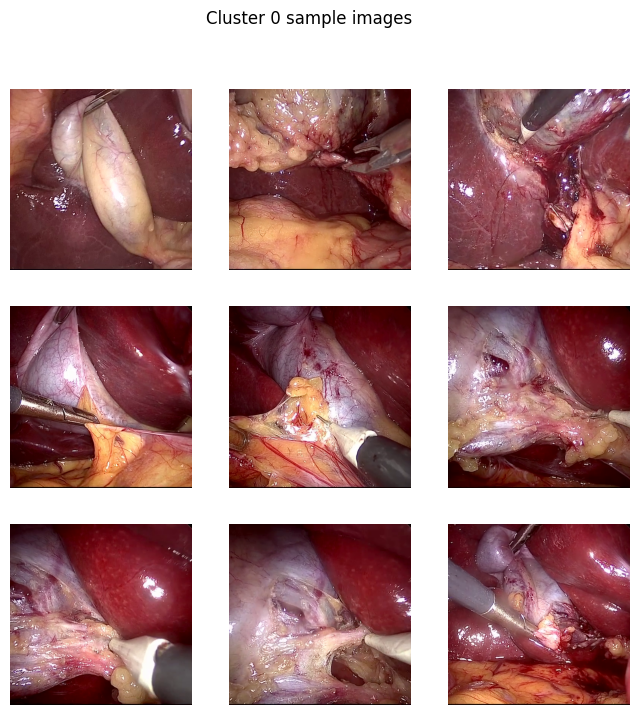

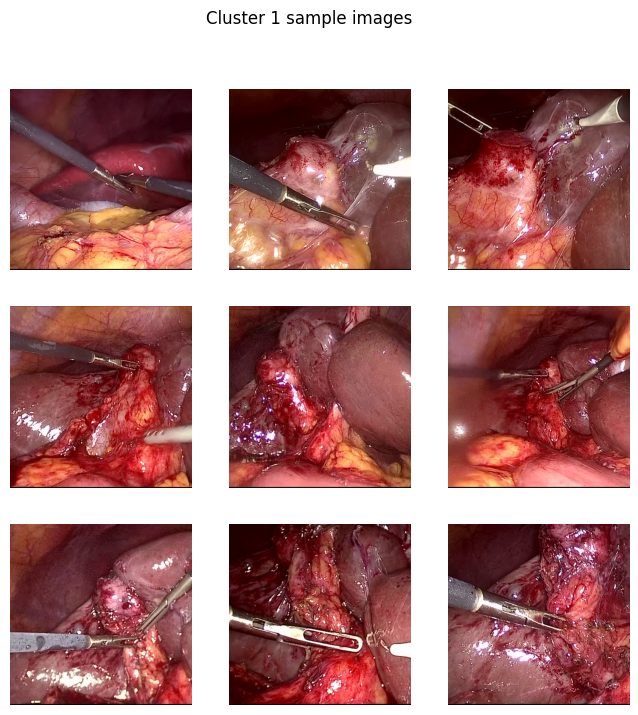

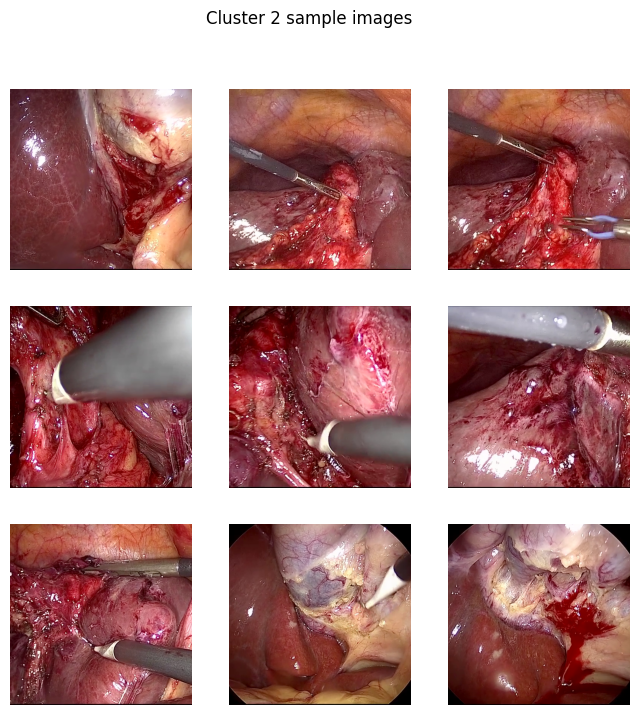

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

def show_cluster_images(cluster_id, n=9):
    cluster_paths = [row.path for row in clustered_df.filter(clustered_df.cluster == cluster_id).select("path").collect()][:n]
    plt.figure(figsize=(8,8))
    for i, path in enumerate(cluster_paths):
        # Strip 'file:' if present
        if path.startswith("file:"):
            path = path.replace("file:", "")
        img = Image.open(path)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} sample images")
    plt.show()

# Show sample images per cluster
show_cluster_images(0)
show_cluster_images(1)
show_cluster_images(2)
